In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from functions import aux_functions

## Read dataset

In [2]:
hardbounce = pd.read_csv('datasets/hardbounce_featureEngineering.csv',sep=';')

## Build dummy variables

In [3]:
cat_vars=['emailDomain_cat','emailDomainPiece1','emailDomainPiece2']

hardbounce_dummy = aux_functions.buildDummyVariables(hardbounce, cat_vars)

## Check imbalance

In [4]:
aux_functions.freqTable(
    hardbounce_dummy['flgHardBounce_n']
    ,""
    ,False
    ,"columns"
)

flgHardBounce_n
0    0.787886
1    0.212114
Name: __dummy__, dtype: float64

## Oversample dataset

In [5]:
x_vars = ['monthsSinceRegDate', 'age', 'percNumbersInEmailUser', 'emailUserCharQty', 
          'emailDomain_cat_gmail.com', 'emailDomain_cat_hotmail.com',
          'emailDomainPiece1_com',
          'emailDomainPiece2_br', 'emailDomainPiece2_missing']

X = hardbounce_dummy[x_vars]

y = hardbounce_dummy['flgHardBounce_n']

In [6]:
X_resampled, y_resampled = aux_functions.oversampleSMOTE(X, y)

In [7]:
aux_functions.freqTable(
    y_resampled['flgHardBounce_n']
    ,""
    ,False
    ,"columns"
)

flgHardBounce_n
0    0.5
1    0.5
Name: __dummy__, dtype: float64

## Split dataset in Train / Test

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, np.ravel(y_resampled), test_size=0.30, random_state=123)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(533205, 9)
(228517, 9)
(533205,)
(228517,)


## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [10]:
# Random Forest Classifier Train

rf_classif = RandomForestClassifier(random_state=123)

rf_classif.fit(X_train,y_train)

/home/thiago/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

### Probability Thresholds

(0, 1)

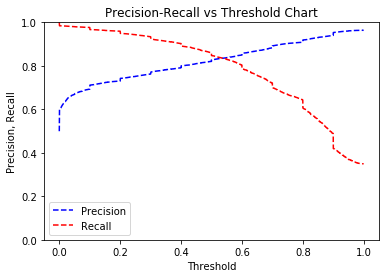

In [11]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Predict
y_scores_threshold = rf_classif.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_threshold) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [12]:
# Random Forest Classifier predict

threshold = 0.5

y_pred = np.where(rf_classif.predict_proba(X_test)[:,1] > threshold, 1, 0)
y_scores = rf_classif.predict_proba(X_test)[:,1]

### F1-score, precision and recall

In [13]:
from sklearn.metrics import classification_report
target_names = hardbounce_dummy['flgHardBounce_n'].astype('str').unique()
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.84      0.82      0.83    114393
           0       0.83      0.85      0.84    114124

    accuracy                           0.84    228517
   macro avg       0.84      0.84      0.84    228517
weighted avg       0.84      0.84      0.84    228517



### Accuracy

In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8359378076904563


### Plot Confusion Matrix

Normalized confusion matrix
[[0.82439485 0.17560515]
 [0.15249203 0.84750797]]


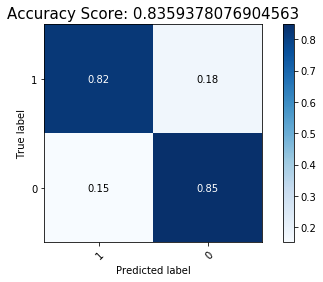

In [15]:
class_names = hardbounce_dummy['flgHardBounce_n'].astype('str').unique()
aux_functions.plot_confusion_matrix(y_test, y_pred, classes=class_names, cmap=plt.cm.Blues, normalize=True)

### AVG Precision Score

In [16]:
print("AVG Precision Score: ", metrics.average_precision_score(y_test, y_scores))

AVG Precision Score:  0.9028691206253965


### AUC

In [17]:
auc_metric = metrics.roc_auc_score(y_test, y_scores)
print("AUC: %.4f" % auc_metric)

AUC: 0.9137


### ROC Curve

AUC: 0.9137


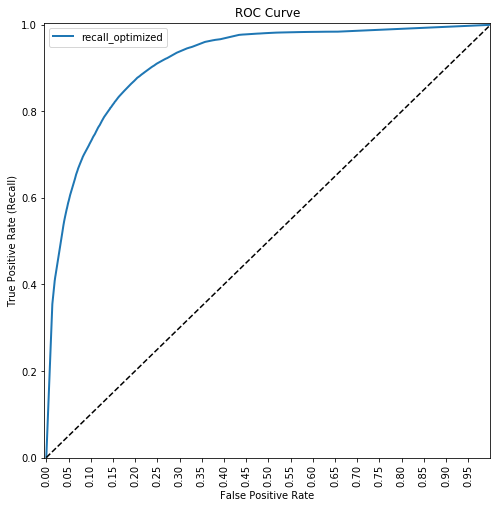

In [18]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_scores)
print("AUC: %.4f" % metrics.auc(fpr, tpr)) # AUC of ROC
aux_functions.plot_roc_curve(fpr, tpr, 'recall_optimized')

### Plot Variable Importance

No handles with labels found to put in legend.


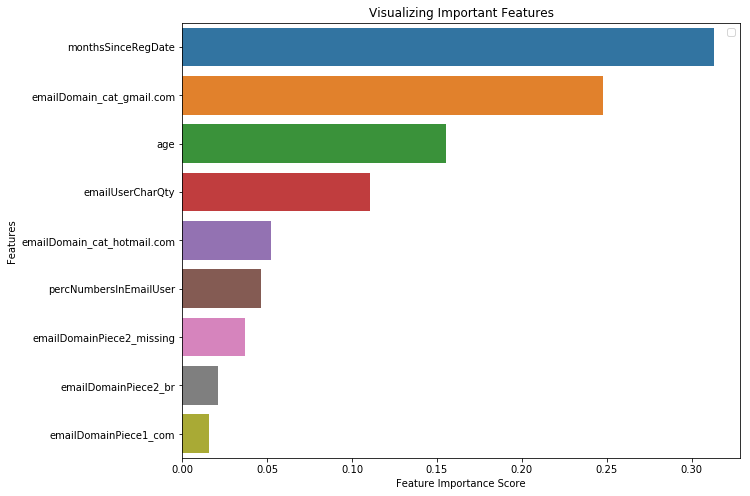

In [21]:
feature_imp = pd.Series(rf_classif.feature_importances_,index=X_train.columns).sort_values(ascending=False)
aux_functions.plot_feature_importance(feature_imp, feature_imp.index)

## Save Model

In [22]:
import pickle

pickle.dump(rf_classif, open('models/rf-classifier.sav', 'wb'))